# Test (classification supervised learning)

In [1]:
%matplotlib inline

In [2]:
%run setup_environment.py
%run custom_tools.py
%run ml_tools.py

current_conda_env = !echo $CONDA_DEFAULT_ENV
check_conda_env(current_conda_env[0])

Setup environment... done!


✅ <span style='color:green'>Working on **impact-annotator_env** conda environment.</span>

In [3]:
impact = pd.read_csv('../../data/annotated_final_IMPACT_mutations_180508.txt', sep = '\t', low_memory = False)

impact.shape

(194211, 63)

## Feature processsing

### `is_somatic`

In [4]:
get_table(impact.confidence_class)

,count_,freq_
AUTO_OK,180832,93.1%
UNLIKELY,7199,3.7%
MANUAL_OK,6180,3.2%


In [5]:
impact['is_somatic'] = impact.confidence_class == "UNLIKELY"
get_table(impact.is_somatic)

,count_,freq_
False,187012,96.3%
True,7199,3.7%


## Setup the train/test sets

### Choose label

In [46]:
label_feature_name = 'is_somatic'

In [47]:
# shuffle data
rng = np.random.RandomState(0)
permutation = rng.permutation(len(impact))
impact_sel = impact.iloc[permutation]

impact_sel = impact_sel.iloc[0:20000]

### Choose features

In [48]:
feature_names = [
# 'Hugo_Symbol', 'Chromosome', 'Start_Position', 'End_Position', 'Consequence', 'Variant_Type', 'Reference_Allele', 'Tumor_Seq_Allele2', 'Tumor_Sample_Barcode',
# 'cDNA_change', 'HGVSp_Short',
't_depth', 't_vaf', 't_alt_count', 'n_depth', 'n_vaf', 'n_alt_count',
# 't_ref_plus_count', 't_ref_neg_count', 't_alt_plus_count', 't_alt_neg_count',
#'confidence_class',
'sample_coverage',
#'mut_key',
#'VAG_VT', 'VAG_GENE', 'VAG_cDNA_CHANGE', 'VAG_PROTEIN_CHANGE', 'VAG_EFFECT',
'VEP_Consequence',
#'VEP_SYMBOL', 'VEP_HGVSc', 'VEP_HGVSp',
#'VEP_Amino_acids',
'VEP_VARIANT_CLASS',
#'VEP_EXON', 'VEP_INTRON',
'VEP_IMPACT',
'VEP_CLIN_SIG',
'VEP_COSMIC_CNT',
'VEP_gnomAD_AF',
#'sample_mut_key', 'patient_key',
'frequency_in_normals',
#'VEP_SIFT_class',
#'VEP_SIFT_score',
#'VEP_PolyPhen_class',
#'VEP_PolyPhen_score',
'VEP_in_dbSNP',
'VEP_gnomAD_total_AF_AFR',
'VEP_gnomAD_total_AF_AMR',
'VEP_gnomAD_total_AF_ASJ',
'VEP_gnomAD_total_AF_EAS',
'VEP_gnomAD_total_AF_FIN',
'VEP_gnomAD_total_AF_NFE',
'VEP_gnomAD_total_AF_OTH',
'VEP_gnomAD_total_AF_max',
'VEP_gnomAD_total_AF',
'Kaviar_AF',
# 'is_a_hotspot',
# 'is_a_3d_hotspot',
# 'oncogenic',
'gene_type',
label_feature_name
]

categorical_features_names = [
'VEP_Consequence',
#'VEP_Amino_acids',
'VEP_VARIANT_CLASS',
'VEP_IMPACT',
'VEP_CLIN_SIG',
#'VEP_SIFT_class',
#'VEP_PolyPhen_class',
'VEP_in_dbSNP',
'gene_type',
]

In [49]:
impact_sel = impact_sel[feature_names].dropna()
impact_sel.shape

(20000, 27)

In [50]:
impact_sel = pd.get_dummies(impact_sel, columns = categorical_features_names, sparse = True)
impact_sel.shape

(20000, 46)

### Split features from label

In [51]:
X = impact_sel.drop(label_feature_name, axis = 1) # features matrix X: [n_samples, n_features]
y = impact_sel[label_feature_name]                # target array y: n_samples
print(X.shape)
print(y.shape)

(20000, 45)
(20000,)


In [52]:
get_table(y)

,count_,freq_
False,19260,96.3%
True,740,3.7%


In [53]:
n_folds = 5

## Main functions

In [56]:
i = 0
for train_index, test_index in cv_strategy.split(X, y):
    print("Fold %d :\n" % i,
          "\t- train_index (%5d elements) %s\n" % (len(train_index), str(train_index)),
          "\t- test_index  (%5d elements) %s" % (len(test_index), str(test_index)))
    i += 1

Fold 0 :
 	- train_index (16000 elements) [ 6673 19272 13022 ...  1983 18184  9215]
 	- test_index  ( 4000 elements) [13339  2381 18563 ...  6145  6526 16997]
Fold 1 :
 	- train_index (16000 elements) [16412  6587 11506 ...  3193 14082 16137]
 	- test_index  ( 4000 elements) [8237 3619 8561 ... 3526 8373 2338]
Fold 2 :
 	- train_index (16000 elements) [ 1852  6519  3784 ... 12719  9048 11758]
 	- test_index  ( 4000 elements) [ 4446 14899   131 ...  4528  7904 19962]
Fold 3 :
 	- train_index (16000 elements) [ 7030 16241 18394 ...  6928  7343 14285]
 	- test_index  ( 4000 elements) [14583  3791 14657 ... 17452 10917  4045]
Fold 4 :
 	- train_index (16000 elements) [19193 15658 13080 ... 15590 14574  3640]
 	- test_index  ( 4000 elements) [ 7889  5227 18167 ... 11506 16334 12040]


In [55]:
from sklearn.model_selection import StratifiedShuffleSplit

# returns stratified randomized folds. The folds are made by preserving the percentage of samples for each class.
cv_strategy = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 1)

In [71]:
from sklearn.model_selection import cross_validate

def print_train_test_metrics(metrics, fold_number):
    print("Fold #: [fit_time | score_time]\n",
          "  → accuracy: [test_accuracy | train_accuracy]\n",
          "  → ROC AUC : [test_roc_auc  | train_roc_auc]\n")
    
    for i in range(fold_number):
        print("Fold %d: [%.2fs | %.2fs]\n"    % (i, metrics['fit_time'][i], metrics['score_time'][i]) +
              "  → accuracy: [%.3f | %.3f]\n" % (metrics['test_accuracy'][i], metrics['train_accuracy'][i]) +
              "  → ROC AUC : [%.3f | %.3f]"   % (metrics['test_roc_auc'][i]  , metrics['train_roc_auc'][i]))
        
    print()

def run(model, X, y, cv_strategy, print_fold_metrics = False, plot_roc = False):
    scoring_metrics = ['accuracy', 'roc_auc']
    
    metrics = cross_validate(model, X, y, cv = cv_strategy, scoring = scoring_metrics, return_train_score = True) # n_jobs, pre_dispatch
    
    if print_fold_metrics:
        print_train_test_metrics(metrics, cv_strategy.get_n_splits())
    
    # mean metrics and 95% confidence interval on the metrics estimate (= 1.96 x standard_deviation)
    print("## Accuracy: %0.2f ± %0.2f\n" % (np.mean(metrics['test_accuracy']),
                                                1.96 * np.std(metrics['test_accuracy'])) +
          "## ROC AUC : %0.2f ± %0.2f" % (np.mean(metrics['test_roc_auc']),
                                              1.96 * np.std(metrics['test_roc_auc'])))

# strongly inspired by http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
def run_roc(model, X, y, cv_strategy, ax):
    from scipy import interp
    from sklearn.metrics import roc_curve, auc
    
    mean_fpr = np.linspace(0, 1, 100) # [0, 0.01, 0.02, ..., 0.09]
    tprs = [] # True Positive Rate for each fold
    aucs = [] # ROC AUC for each fold
            
    i = 0
    for train_index, test_index in cv_strategy.split(X, y):
        model.fit(X.iloc[train_index], y.iloc[train_index])
        y_pred = model.predict_proba(X.iloc[test_index])
        # y_pred: 1st column = proba of 0 (y_pred[:, 0]), 2nd column = proba of 1 (y_pred[:, 1])
        
        # fpr: false positive rate
        # tpr: true positive rate
        fpr, tpr, thresholds = roc_curve(y.iloc[test_index], y_pred[:, 1])
                
        # because the length of fpr and tpr vary with the fold (size of thersholds  = nunique(y_pred[:, 1]) + 1), we can't just do
        # fprs.append(fpr) and tprs.append(tpr)
        tprs.append(interp(mean_fpr, fpr, tpr)) # linear interpolation to find the values for a 100 tpr
        tprs[-1][0] = 0.0 # threshold > 1 for the first point
        
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        
        ax.plot(fpr, tpr, linewidth = 0.5, alpha = 0.4,
                label = 'ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i += 1
        
    ax.plot([0, 1], [0, 1], '--r', linewidth = 0.5, alpha = 0.8, label = 'random')
    
    ##############
    ## mean ROC ##
    ##############
    mean_tpr = np.mean(tprs, axis = 0)
    ax.plot(mean_fpr, mean_tpr, 'b', linewidth = 1,
            label = 'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (np.mean(aucs), 1.96 * np.std(aucs)))

    ##################
    ## mean ROC std ##
    ##################
    std_tprs = np.std(tprs, axis = 0)
    ax.fill_between(mean_fpr, mean_tpr - std_tprs, mean_tpr + std_tprs, color = 'blue', alpha = 0.2,
                     label='$\pm$ 1 std. dev.')

    
    #####################
    ## plot parameters ##
    #####################
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc = "lower right", prop = {'size': 10})

## Accuracy: 0.92 ± 0.02
## ROC AUC : 0.79 ± 0.03


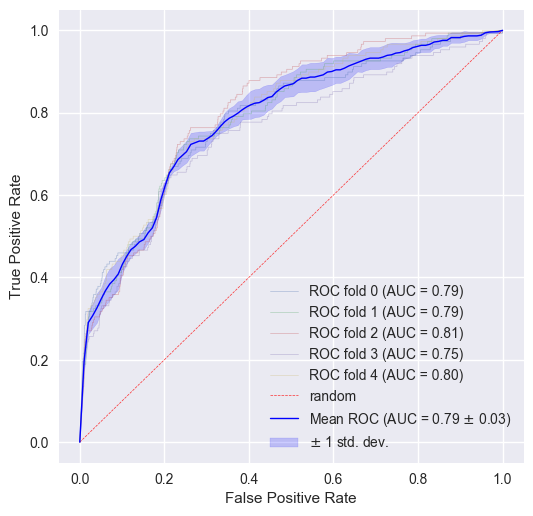

In [72]:
from sklearn.naive_bayes import GaussianNB

model_GaussianNB = GaussianNB()

run(model_GaussianNB, X, y, cv_strategy, plot_roc = True)
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
run_roc(model_GaussianNB, X, y, cv_strategy, ax)

## Dummy

Two "dummy" models:
* `Uniform`: generates predictions uniformly at random  
    → expected accuracy: 0.5 | expected AUC: 0.5
* `Most frequent`: always predicts the most frequent label in the training set  
    → expected accuracy: proportion of the most reccurent class in the dataset | expected AUC: 0.5

In [24]:
from sklearn.dummy import DummyClassifier

model_uniform       = DummyClassifier(strategy = 'uniform'      , random_state = 1)
model_most_frequent = DummyClassifier(strategy = 'most_frequent', random_state = 1)

get_accuracy_and_AUC(model_uniform      , X, y, cv_strategy, 'Uniform')
get_accuracy_and_AUC(model_most_frequent, X, y, cv_strategy, 'Most Frequent')

#fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6))
#plot_cross_validation_ROC_curves(model_uniform      , X, y, n_folds, 'Uniform'      , ax1);
#plot_cross_validation_ROC_curves(model_most_frequent, X, y, n_folds, 'Most Frequent', ax2);

**Uniform** Accuracy: 0.51 ± 0.00 | AUC: 0.50 ± 0.00

**Most Frequent** Accuracy: 0.96 ± 0.00 | AUC: 0.50 ± 0.00

## Gaussian Naive Bayes

**Gaussian Naive Bayes** Accuracy: 0.87 ± 0.00 | AUC: 0.91 ± 0.00

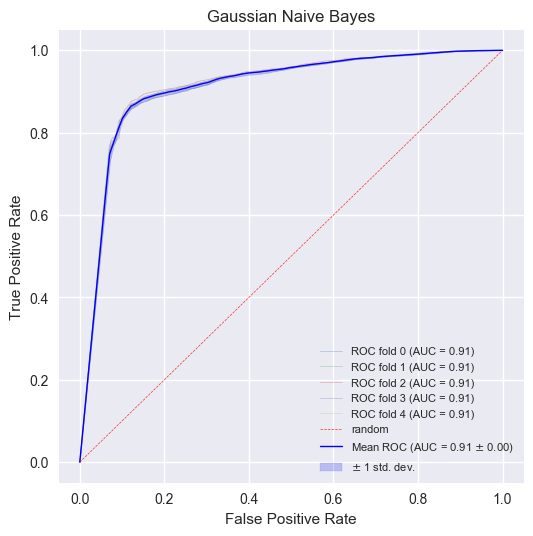

In [61]:
from sklearn.naive_bayes import GaussianNB

model_GaussianNB = GaussianNB()

get_accuracy_and_AUC(model_GaussianNB, X, y, n_folds, 'Gaussian Naive Bayes')

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
plot_cross_validation_ROC_curves(model_GaussianNB, X, y, n_folds, 'Gaussian Naive Bayes', ax)

## Logistic Regression

In [62]:
%run ml_tools.py

<Figure size 1000x400 with 0 Axes>

**Logistic Regression** Accuracy: 0.97 ± 0.00 | AUC: 0.82 ± 0.04

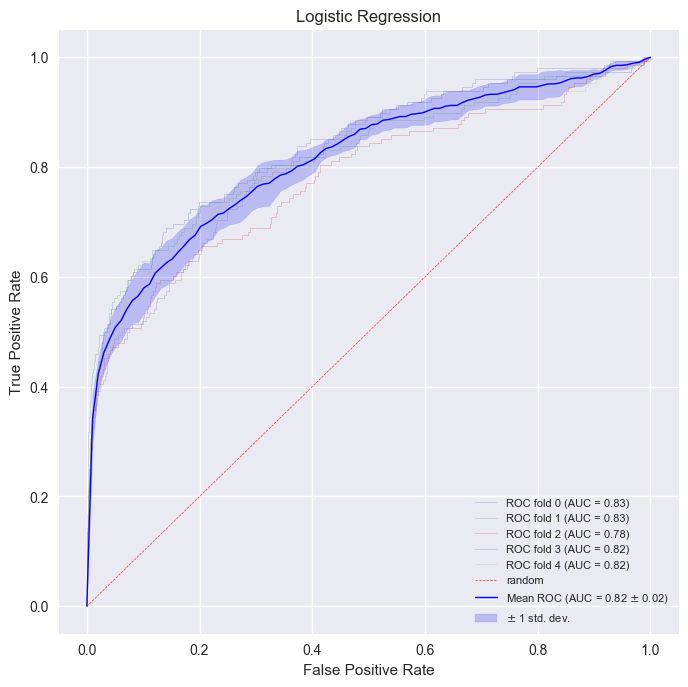

In [25]:
from sklearn.linear_model import LogisticRegression

model_LogisticRegression = LogisticRegression(random_state = 1)

get_accuracy_and_AUC(model_LogisticRegression, X, y, cv_strategy, 'Logistic Regression')


fig, ax = plt.subplots(1, 1, figsize = (8, 8))
plot_cross_validation_ROC_curves(model_LogisticRegression, X, y, n_folds, 'Logistic Regression', ax)

In [ ]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(model, X, y, train_sizes = np.linspace(0.1, 1.0, 5), cv = 5)

for i in range(n_folds):
    plt.plot(train_sizes, train_scores[i], linewidth = 0.5, alpha = 0.4, color = 'r',
                     label = 'training score fold %d' % i)
    plt.plot(train_sizes, test_scores[i], linewidth = 0.5, alpha = 0.4, color = 'g',
                     label = 'test score fold %d' % i)
    
train_scores_mean = np.mean(train_scores, axis = 0)
train_scores_std = np.std(train_scores, axis = 0)
test_scores_mean = np.mean(test_scores, axis = 0)
test_scores_std = np.std(test_scores, axis = 0)

plt.plot(train_sizes, train_scores_mean, 'o-r', linewidth = 1,
        label = 'mean training score')
plt.plot(train_sizes, test_scores_mean, 'o-g', linewidth = 1,
         label = 'mean test score')

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha = 0.1, color = 'r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha = 0.1, color = 'g')


plt.xlabel("Training size")
plt.ylabel("Accuracy score")
plt.legend(loc = "lower right", prop = {'size': 5})

## K Nearest Neighbors

**K Nearest Neighbors** Accuracy: 0.89 ± 0.00 | AUC: 0.81 ± 0.01

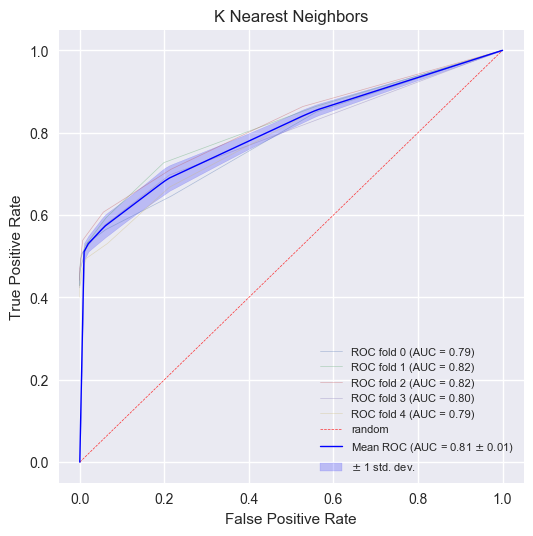

In [70]:
from sklearn.neighbors import KNeighborsClassifier

model_KNeighborsClassifier = KNeighborsClassifier(n_neighbors = 10)

get_accuracy_and_AUC(model_KNeighborsClassifier, X, y, n_folds, 'K Nearest Neighbors')

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
plot_cross_validation_ROC_curves(model_KNeighborsClassifier, X, y, n_folds, 'K Nearest Neighbors', ax);

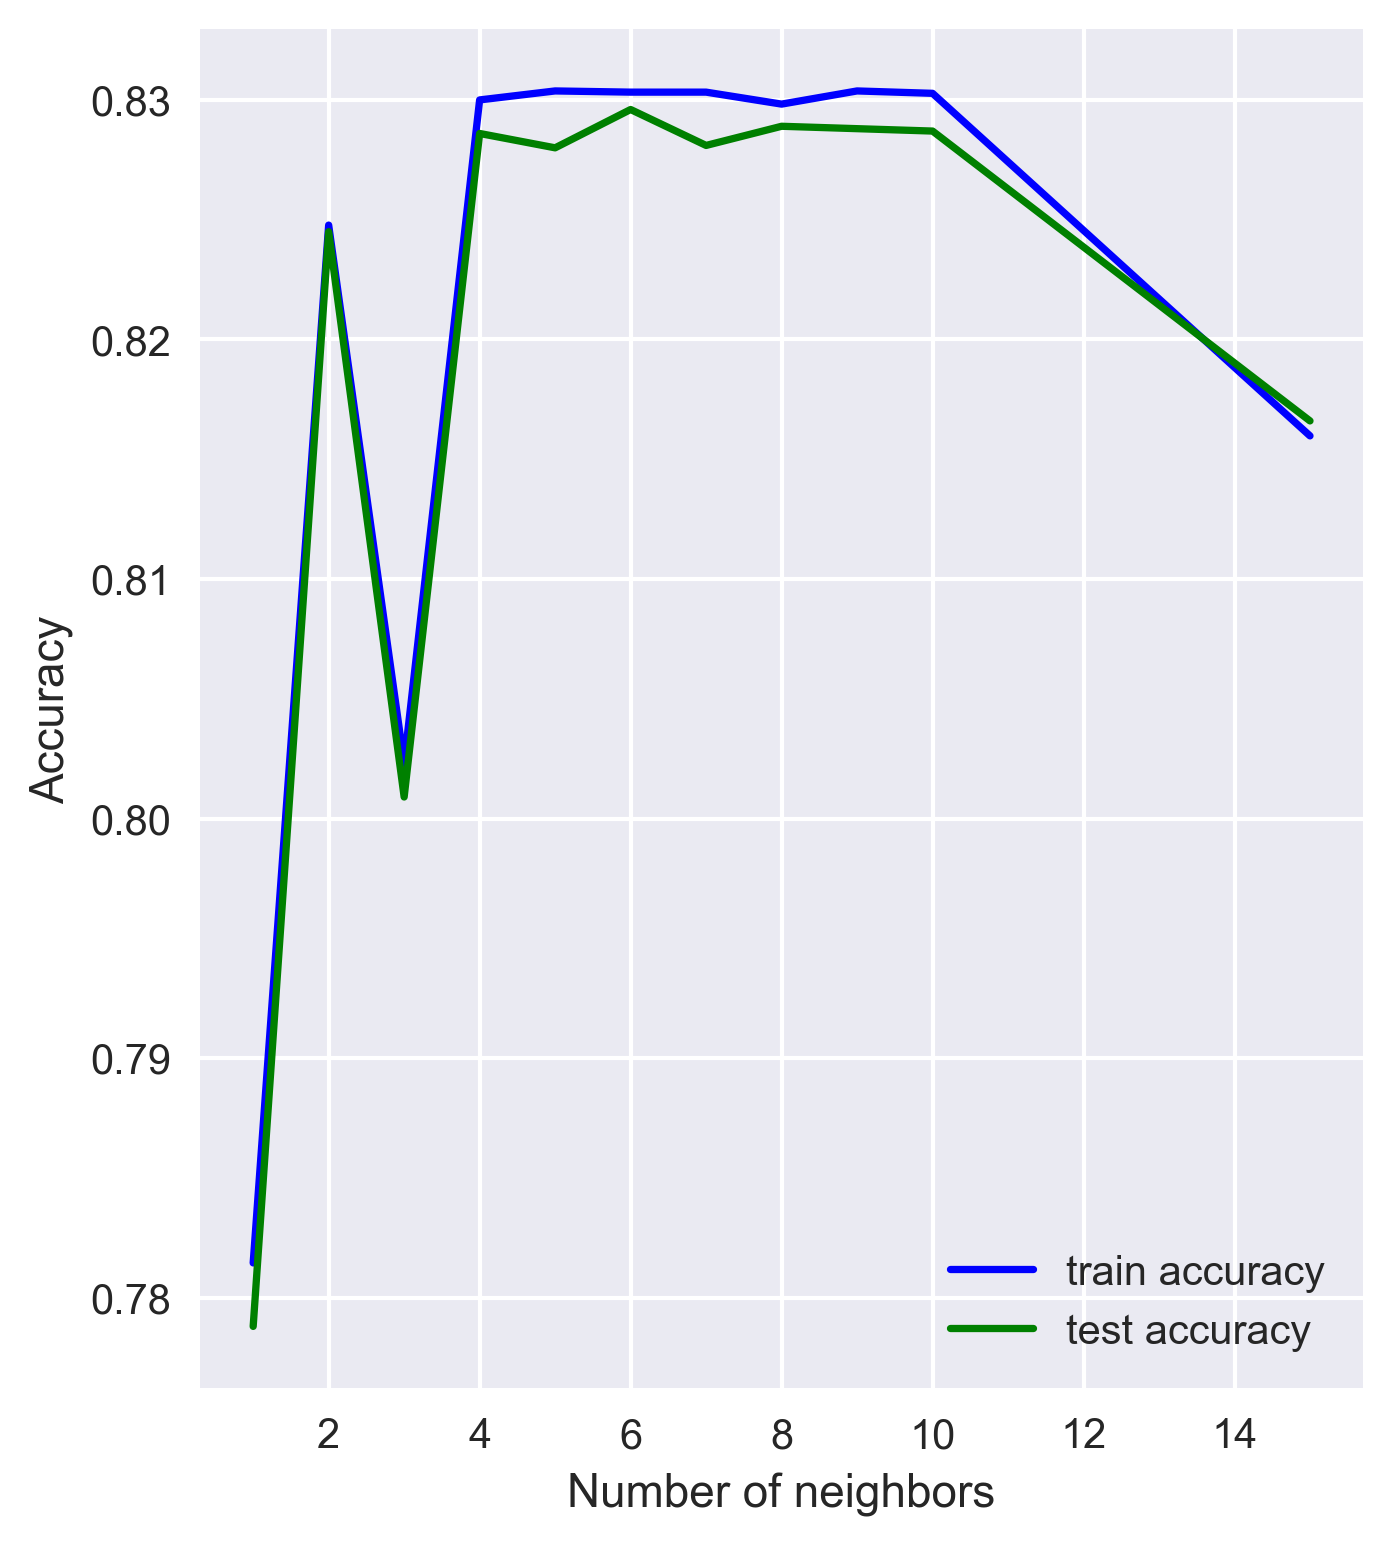

In [110]:
from sklearn.model_selection import validation_curve
n_neighbors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15]
train_scores, test_scores = validation_curve(KNeighborsClassifier(), X, y, param_name = "n_neighbors", param_range = n_neighbors, cv = n_folds)

plt.figure(figsize = (5, 6))
plt.plot(n_neighbors, train_scores.mean(axis = 1), 'b', label = "train accuracy")
plt.plot(n_neighbors, test_scores.mean(axis = 1), 'g', label = "test accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Number of neighbors')
#plt.xlim([50, 0])
plt.legend(loc = "best");

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_RandomForestClassifier = RandomForestClassifier(n_estimators = 200)

get_accuracy_and_AUC(model_RandomForestClassifier, X, y, n_folds, 'Random Forest')

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
plot_cross_validation_ROC_curves(model_RandomForestClassifier, X, y, n_folds, 'Random Forest', ax);

## Support Vector Machine

In [ ]:
from sklearn.svm import SVC

model = SVC(kernel = 'linear', C = 1E10)

accuracy_scores = cross_val_score(model, X, y, cv = 5)
auc_scores = cross_val_score(model, X, y, cv = n_folds, scoring = "roc_auc")
print("Accuracy: %0.2f ± %0.2f | AUC: %0.2f ± %0.2f" % (accuracy_scores.mean(), accuracy_scores.std(), auc_scores.mean(), auc_scores.std()))
plot1 = plot_cross_validation_ROC_curves(model, X, y, n_folds);